# Architectures with Mel Spectrogram as Input
## Audio Classification with the ESC-50 dataset

This notebook performs audio classification on audio fragments of 5 seconds long

In [1]:
# IMPORT ALL LIBRARIES

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import seaborn as sns

import IPython.display as ipd
import librosa
import librosa.display

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.layers import Layer, Dense
from tensorflow.keras.models import Sequential

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## Load the data

### ESC-50 Dataset

In [2]:
# Determine the Sample Rate to load the audio files

SR = 16000

In [3]:
info = pd.read_csv('/kaggle/input/esc50dataset/ESC-50-master/ESC-50-master/meta/esc50.csv')

info_list = list(info['category'].unique())

labels = {}

for i, label in enumerate(info_list):
        labels[label] = i

NUM_CLASSES = len(labels)

# Create a new empty dictionary
reversed_labels = {}

# Iterate through the key-value pairs in the dictionary
for key, value in labels.items():
  # Add the key-value pair to the new dictionary in the reverse order
  reversed_labels[value] = key
    
esc50_files = list(info['filename'])

### Load the wav files

The data loader `wav_data_loader()` runs normalization with librosa's integrated util: https://librosa.org/doc/main/generated/librosa.util.normalize.html

Normalization can be disabled if later audio processing techniques apply normalization. In the code of this project, normalization is integrated in the `tf_mel_spectrogram()` function.

`wav_data_loader()` loads the wav files with their corresponding labels as a tuple.

In [4]:
ESC50_FOLDER = '/kaggle/input/esc50dataset/ESC-50-master/ESC-50-master/audio'

In [5]:
def wav_data_loader(files, normalization=True):
    
    all_fragments = []
    
    for file in files:
        
        # Load the audio file
        
        AUDIO_FILE = os.path.join(ESC50_FOLDER, file)
        
        sample, sample_rate = librosa.load(AUDIO_FILE, sr=SR)
        
        if normalization==True:
            
            # Normalize the waveform
            sample = librosa.util.normalize(sample)
        
        cat = info[info['filename'] == file]['category'].iloc[0]
        
        sample = (sample, labels[cat])    
    
        all_fragments.append(sample)
    
    return all_fragments

In [6]:
%%time
esc50_wav_dataset = wav_data_loader(esc50_files, normalization=False)

CPU times: user 18.2 s, sys: 1.5 s, total: 19.7 s
Wall time: 47.3 s


In [7]:
len(esc50_wav_dataset)

2000

## Train-test split

Creating a first train-test split in the original dataset will be useful for correct data augmentation and pre-processing techniques.

In [8]:
X = [wav[0] for wav in esc50_wav_dataset]
y = [wav[1] for wav in esc50_wav_dataset]

X_train_wav, X_test_wav, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_train_wav, X_val_wav, y_train, y_val = train_test_split(X_train_wav, y_train, test_size=0.2, stratify=y_train, random_state=42)

## Waveform augmentation

In [9]:
## Noise addition

def add_noise(wav_data, noise_factor):

    # Generate noise signal with the same shape as input waveform
    noise = np.random.normal(0, 1, len(wav_data))

    # Scale noise signal with the permissible noise factor value
    noise *= noise_factor

    # Add noise signal to input waveform
    augmented_wav_data = wav_data + noise

    # Normalize the augmented waveform data
    augmented_wav_data = librosa.util.normalize(augmented_wav_data)

    return augmented_wav_data

def time_shift(audio, p):
    """
    Shift audio to the left or right by a random amount.
    """
    # Calculate the length of the audio array
    length = audio.shape[0]

    # Calculate the maximum number of samples to shift
    max_shift = int(length * p)

    # Generate a random shift value
    shift = random.randint(-max_shift, max_shift)

    # Create an empty array with the same shape as the audio array
    shifted_audio = np.zeros_like(audio)

    # Shift the audio by the specified number of samples
    if shift > 0:
      # Shift to the right
        shifted_audio[shift:] = audio[:length-shift]
    else:
        # Shift to the left
        shifted_audio[:length+shift] = audio[-shift:]
    
    if np.sum(shifted_audio) == 0:
        #revert the process if all information was erased
        shifted_audio = audio     

    return shifted_audio

def time_stretching(audio,factor):
    
    wav_time_stch = librosa.effects.time_stretch(audio,rate=factor)
    
    return wav_time_stch[:SR*5]

In [10]:
len(X_train_wav)

1120

In [11]:
%%time
''' EXUCUTE THIS CELL TO APPLY DATA AUGMENTATION
Lots of memory required this step could be optimized'''

def augment_wavs(wav_dataset, y):
    
    wav_dataset_augmented = []

    for wav in wav_dataset:
        # Create a copy of the original wav to prevent unwanted side effects
        temp_wav = wav.copy()
        temp_wav = add_noise(temp_wav, 0.025) # We want to use values between 0.005 and 0.04
        temp_wav = time_shift(temp_wav, 0.3)  # We want to use a max shift of 30%
        temp_wav = time_stretching(temp_wav, 0.85)

        wav_dataset_augmented.append(temp_wav)

    # Add original wavs to augmented list
    wav_dataset_augmented.extend(wav_dataset)
    
    y = y + y #each spec is being appended at the bottom of the list

    return wav_dataset_augmented, y

X_train_wav, y_train = augment_wavs(X_train_wav, y_train)

CPU times: user 1min 3s, sys: 553 ms, total: 1min 3s
Wall time: 1min 4s


In [12]:
len(X_train_wav)

2240

In [13]:
len(y_train)

2240

## Mel Spectrogram Generator

In [14]:
def tf_mel_spectrogram(wav, sample_rate=SR, num_mel_bins=64, lower_freq=125, upper_freq=7500, log_offset=0.001):
    
    # Convert numpy array to Tensor and normalize based on its actual max and min values
    wav = tf.cast(wav, tf.float32)
    audio_tensor = (wav - tf.math.reduce_min(wav)) / (tf.math.reduce_max(wav) - tf.math.reduce_min(wav)) * 2 - 1

    # Calculate the frame_length and frame_step based on window size and hop size
    frame_length = int(sample_rate * 0.025)  # 25 ms window
    frame_step = int(sample_rate * 0.01)  # 10 ms hop

    # Calculate the spectrogram
    spectrogram = tf.signal.stft(audio_tensor, frame_length=frame_length, frame_step=frame_step, window_fn=tf.signal.hann_window)

    # Calculate the magnitude of the spectrogram
    magnitude_spectrogram = tf.abs(spectrogram)

    # Define the parameters for the Mel scale
    num_spectrogram_bins = magnitude_spectrogram.shape[-1]
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, num_spectrogram_bins, sample_rate, lower_freq, upper_freq)

    # Convert the spectrogram to the Mel scale
    mel_spectrogram = tf.tensordot(magnitude_spectrogram, linear_to_mel_weight_matrix, 1)
    mel_spectrogram.set_shape(magnitude_spectrogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

    # Apply a logarithmic scale
    log_mel_spectrogram = tf.math.log(mel_spectrogram + log_offset)

    return log_mel_spectrogram.numpy()

In [15]:
%%time

X_train_specs = []

X_train_specs = list(map(lambda x: tf_mel_spectrogram(x), X_train_wav))

X_val_specs = []

X_val_specs = list(map(lambda x: tf_mel_spectrogram(x), X_val_wav))

X_test_specs = []

X_test_specs = list(map(lambda x: tf_mel_spectrogram(x), X_test_wav))

CPU times: user 1min 32s, sys: 6.65 s, total: 1min 39s
Wall time: 1min 38s


In [16]:
len(X_train_specs)

2240

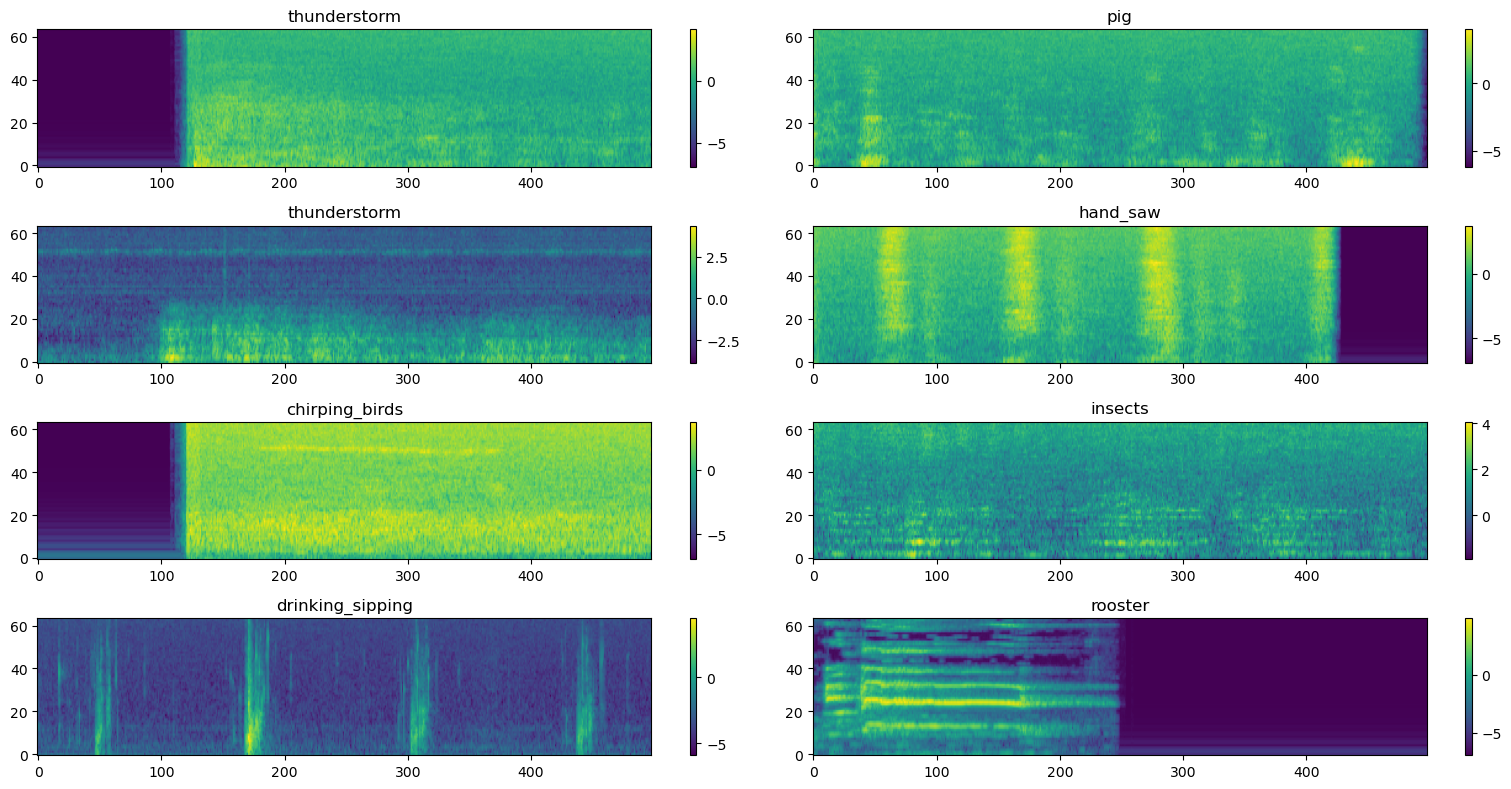

In [17]:
# View 8 random spectrograms
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(16,8))

# Generate 8 random indices
indices = np.random.choice(len(y_train), size=8, replace=False)

for i, ax in enumerate(axs.ravel()):
    idx = indices[i]  # use the randomly generated index
    ax.set_title(reversed_labels[y_train[idx]])
    spectrogram = X_train_specs[idx].T  # Transpose the spectrogram
    img = ax.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')
    fig.colorbar(img, ax=ax)

plt.tight_layout()
plt.show()

## Spectrogram augmentation

In [18]:
# SPECTROGRAM AUGMENTATION

def frequency_mask(spectrogram, p):
    """
    Mask out two percentages of frequencies from the spectrogram.
    """

    # Generate two random start and end points for the masks
    start1 = random.randint(0, spectrogram.shape[0] - 1)
    end1 = min(start1 + int(spectrogram.shape[0]*p), spectrogram.shape[0])

    start2 = random.randint(0, spectrogram.shape[0] - 1)
    end2 = min(start2 + int(spectrogram.shape[0]*p), spectrogram.shape[0])

    # If masks are overlapping, adjust the second mask
    while start1 <= end2 and end1 >= start2:
        start2 = random.randint(0, spectrogram.shape[0] - 1)
        end2 = min(start2 + int(spectrogram.shape[0]*p), spectrogram.shape[0])

    # Create a mask with the same shape as the spectrogram
    mask = np.ones(spectrogram.shape)

    # Set the mask values to zero within the specified range of frequencies
    mask[start1:end1, :] = 0
    mask[start2:end2, :] = 0

    # Apply the mask to the spectrogram
    masked_spectrogram = spectrogram * mask

    return masked_spectrogram

def time_mask(spectrogram, p):
    """
    Mask out two percentages of time from the spectrogram.
    """

    # Generate two random start and end points for the masks
    start1 = random.randint(0, spectrogram.shape[1] - 1)
    end1 = min(start1 + int(spectrogram.shape[1]*p), spectrogram.shape[1])

    start2 = random.randint(0, spectrogram.shape[1] - 1)
    end2 = min(start2 + int(spectrogram.shape[1]*p), spectrogram.shape[1])

    # If masks are overlapping, adjust the second mask
    while start1 <= end2 and end1 >= start2:
        start2 = random.randint(0, spectrogram.shape[1] - 1)
        end2 = min(start2 + int(spectrogram.shape[1]*p), spectrogram.shape[1])

    # Create a mask with the same shape as the spectrogram
    mask = np.ones(spectrogram.shape)

    # Set the mask values to zero within the specified range of time
    mask[:, start1:end1] = 0
    mask[:, start2:end2] = 0

    # Apply the mask to the spectrogram
    masked_spectrogram = spectrogram * mask

    return masked_spectrogram

In [19]:
def augment_spectrograms(X_specs, y):
    
    X_specs_augmented = []

    for spec in X_specs:
        
        # Apply frequency and time masking
        augmented_spectrogram = frequency_mask(spec, 0.15)  # change 'p' as needed
        augmented_spectrogram = time_mask(augmented_spectrogram, 0.1)  # change 'p' as needed

        X_specs_augmented.append(augmented_spectrogram)

    X_specs = X_specs + X_specs_augmented

    y = y + y
    
    return X_specs, y

In [20]:
X_train_specs, y_train = augment_spectrograms(X_train_specs, y_train)

In [21]:
len(X_train_specs)

4480

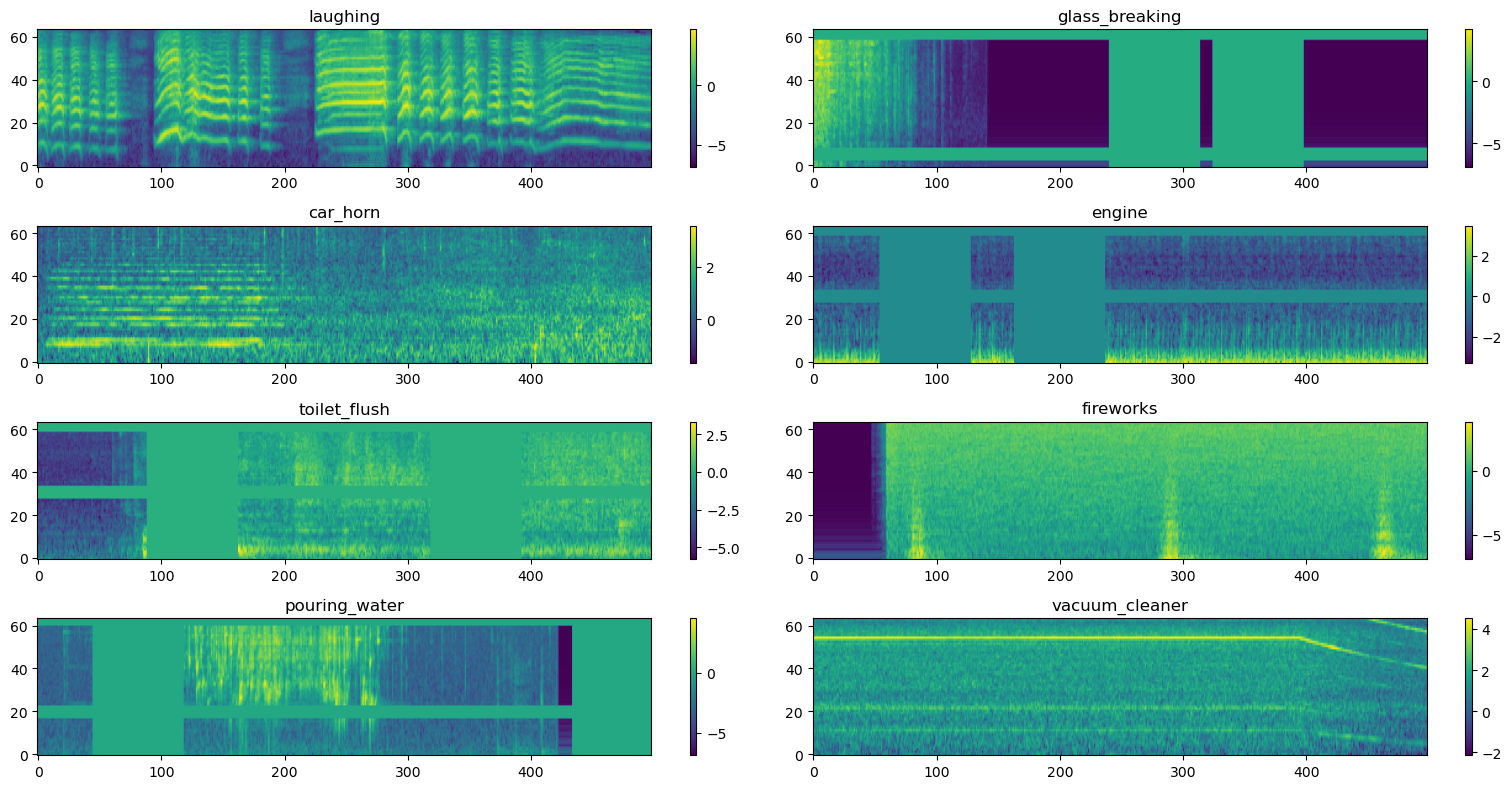

In [22]:
# View 8 random spectrograms
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(16,8))

# Generate 8 random indices
indices = np.random.choice(len(y_train), size=8, replace=False)

for i, ax in enumerate(axs.ravel()):
    idx = indices[i]  # use the randomly generated index
    ax.set_title(reversed_labels[y_train[idx]])
    spectrogram = X_train_specs[idx].T  # Transpose the spectrogram
    img = ax.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')
    fig.colorbar(img, ax=ax)

plt.tight_layout()
plt.show()

# Training

In [23]:
X_train_specs = tf.expand_dims(X_train_specs, -1)  # add a channel dimension
X_val_specs = tf.expand_dims(X_val_specs, -1)  # add a channel dimension
X_test_specs = tf.expand_dims(X_test_specs, -1)  # add a channel dimension

## Basic CNN Architecture

In [44]:
HLF = Sequential([
    tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
])

Embeddings = Sequential([
    tf.keras.layers.Conv2D(256, 1, padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
])

# Define the model
model = Sequential([
    HLF,
    Embeddings,
    tf.keras.layers.Dense(NUM_CLASSES),
    tf.keras.layers.Activation('softmax')  # The activation should be softmax for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(np.array(X_train_specs), np.array(y_train), epochs=50, batch_size=32, validation_data=(np.array(X_val_specs), np.array(y_val)))

Epoch 1/50


2023-06-11 08:24:18.431070: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_11/sequential_10/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


140/140 [==============================] - 6s 20ms/step - loss: 3.4479 - accuracy: 0.1071 - val_loss: 3.5750 - val_accuracy: 0.0893
Epoch 2/50
140/140 [==============================] - 2s 18ms/step - loss: 2.7458 - accuracy: 0.2480 - val_loss: 3.2090 - val_accuracy: 0.1571
Epoch 3/50
140/140 [==============================] - 2s 17ms/step - loss: 2.3203 - accuracy: 0.3473 - val_loss: 2.5609 - val_accuracy: 0.2786
Epoch 4/50
140/140 [==============================] - 2s 17ms/step - loss: 2.0401 - accuracy: 0.4183 - val_loss: 1.9501 - val_accuracy: 0.4679
Epoch 5/50
140/140 [==============================] - 2s 18ms/step - loss: 1.7966 - accuracy: 0.4911 - val_loss: 1.9048 - val_accuracy: 0.4786
Epoch 6/50
140/140 [==============================] - 3s 18ms/step - loss: 1.5979 - accuracy: 0.5455 - val_loss: 2.0235 - val_accuracy: 0.5000
Epoch 7/50
140/140 [==============================] - 2s 18ms/step - loss: 1.4386 - accuracy: 0.5933 - val_loss: 1.7610 - val_accuracy: 0.5857
Epoch 8/50

In [45]:
# Performance Evaluation
test_loss, test_accuracy = model.evaluate(np.array(X_test_specs), np.array(y_test), verbose=2)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

19/19 - 0s - loss: 2.7966 - accuracy: 0.6350 - 124ms/epoch - 7ms/step
Test loss: 2.7965972423553467
Test accuracy: 0.6349999904632568


In [46]:
# Computational complexity evaluation
total_params = model.count_params()
print(f'Total parameters: {total_params}')

Total parameters: 139442


In [47]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (None, 31, 4, 128)        93568     
                                                                 
 sequential_10 (Sequential)  (None, 256)               33024     
                                                                 
 dense_3 (Dense)             (None, 50)                12850     
                                                                 
 activation_3 (Activation)   (None, 50)                0         
                                                                 
Total params: 139,442
Trainable params: 138,994
Non-trainable params: 448
_________________________________________________________________


### Visualization of the training process

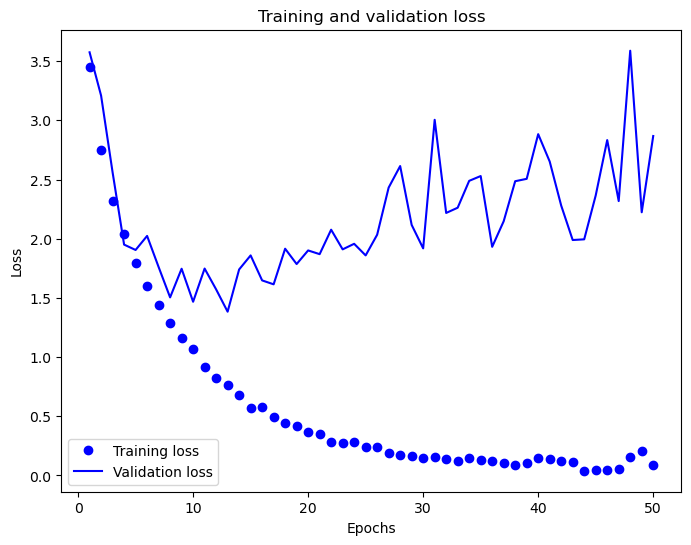

In [48]:
# Plot the loss curves for training and validation.

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

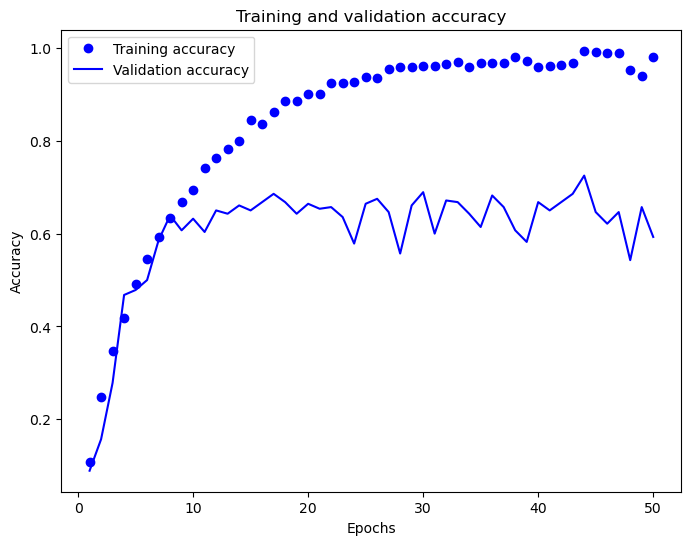

In [49]:
# Plot the accuracy curves for training and validation.

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [50]:
# Save and export the model

model.save('model_esc50_al5s_basic.h5')

In [51]:
# Save arrays to a file
np.savez('checkpoint_1.npz', X_train_specs=X_train_specs, X_val_specs=X_val_specs, X_test_specs=X_test_specs, y_train=y_train, y_val=y_val, y_test=y_test, reversed_labels=reversed_labels)

### Confusion matrix

19/19 [==============================] - 0s 5ms/step


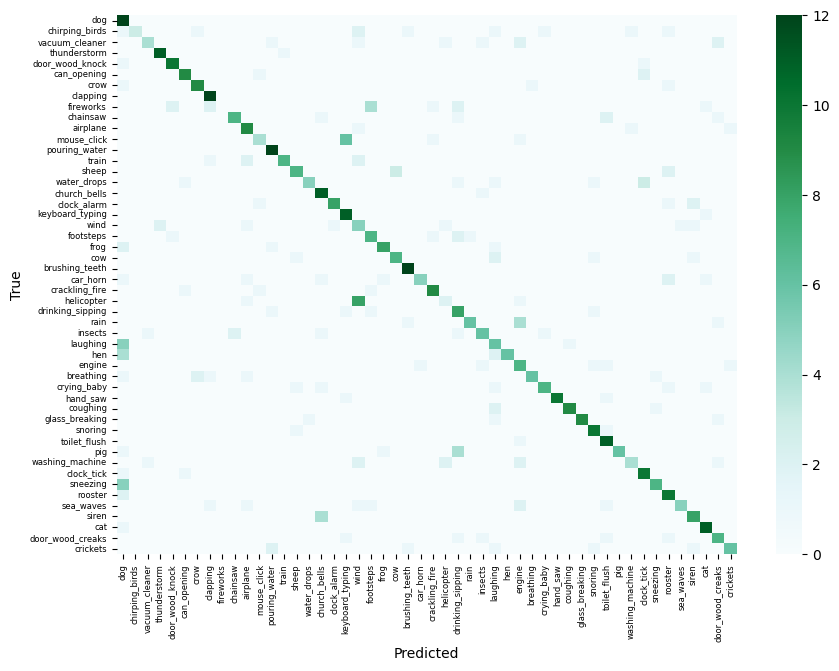

In [52]:
y_true = y_test
y_pred = model.predict(X_test_specs)
y_pred = np.argmax(y_pred, axis=1)

# Get the class names in the order corresponding to the class indices
class_names = [reversed_labels[i] for i in range(len(reversed_labels))]

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting using seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm, cmap="BuGn", xticklabels=class_names, yticklabels=class_names)
plt.tick_params(axis='both', which='major', labelsize=6)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Depth Wise Separable Convolutions

In [ ]:
HLF = Sequential([
    tf.keras.layers.SeparableConv2D(32, 3, strides=2, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.SeparableConv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.SeparableConv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
])

Embeddings = Sequential([
    tf.keras.layers.Conv2D(256, 1, padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
])

# Define the model
model = Sequential([
    HLF,
    Embeddings,
    tf.keras.layers.Dense(NUM_CLASSES),
    tf.keras.layers.Activation('softmax')  # The activation should be softmax for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(np.array(X_train_specs), np.array(y_train), epochs=50, batch_size=32, validation_data=(np.array(X_val_specs), np.array(y_val)))

In [54]:
# Performance Evaluation
test_loss, test_accuracy = model.evaluate(np.array(X_test_specs), np.array(y_test), verbose=2)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

19/19 - 0s - loss: 1.8523 - accuracy: 0.6950 - 121ms/epoch - 6ms/step
Test loss: 1.8522640466690063
Test accuracy: 0.6949999928474426


In [55]:
# Computational complexity evaluation
total_params = model.count_params()
print(f'Total parameters: {total_params}')

Total parameters: 58139


In [56]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (None, 31, 4, 128)        12265     
                                                                 
 sequential_13 (Sequential)  (None, 256)               33024     
                                                                 
 dense_4 (Dense)             (None, 50)                12850     
                                                                 
 activation_4 (Activation)   (None, 50)                0         
                                                                 
Total params: 58,139
Trainable params: 57,691
Non-trainable params: 448
_________________________________________________________________


### Visualization of the training process

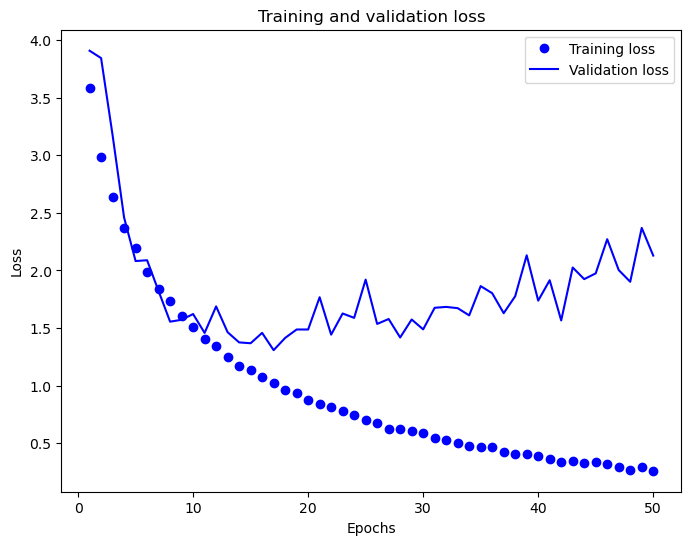

In [57]:
# Plot the loss curves for training and validation.

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

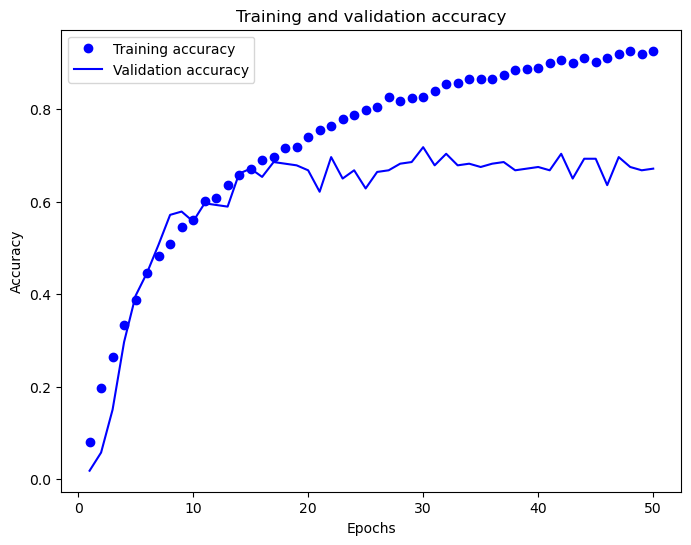

In [58]:
# Plot the accuracy curves for training and validation.

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [59]:
# Save and export the model

model.save('model_esc50_al5s_dw.h5')

In [60]:
# Save arrays to a file
np.savez('checkpoint_1.npz', X_train_specs=X_train_specs, X_val_specs=X_val_specs, X_test_specs=X_test_specs, y_train=y_train, y_val=y_val, y_test=y_test, reversed_labels=reversed_labels)

### Confusion matrix

19/19 [==============================] - 0s 6ms/step


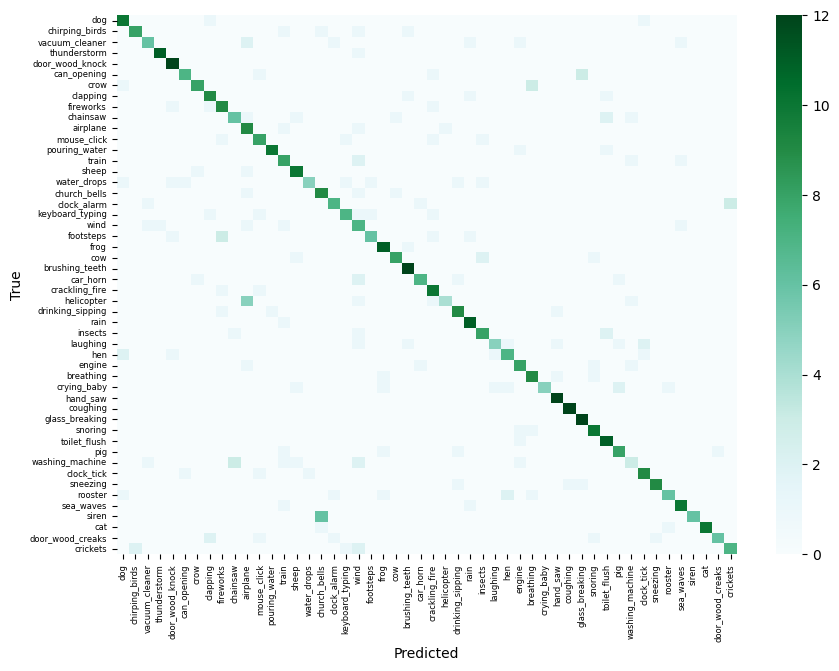

In [61]:
y_true = y_test
y_pred = model.predict(X_test_specs)
y_pred = np.argmax(y_pred, axis=1)

# Get the class names in the order corresponding to the class indices
class_names = [reversed_labels[i] for i in range(len(reversed_labels))]

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting using seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm, cmap="BuGn", xticklabels=class_names, yticklabels=class_names)
plt.tick_params(axis='both', which='major', labelsize=6)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()